In [69]:
import PIL
print('Pillow Version:', PIL.__version__)

Pillow Version: 9.4.0


In [70]:
# importing libraries

%config Completer.use_jedi = False
!pip install tensorflow-addons==0.16.1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from tensorflow.keras.utils import load_img


In [71]:
# connecting to Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

# creates the categories that we classify into
categories = ['Benign cases', 'Malignant cases', 'Normal cases']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# getting the path to the dataset from Google Drive
directory = r'/content/drive/MyDrive/Lung Nodules Dataset/Training set/Training set'


In [73]:
# counts the number of images of each image size
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

size_data

<ipython-input-73-b77470758d58>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Benign cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '404 x 511': 1,
  '512 x 801': 28,
  '512 x 623': 31},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Benign cases


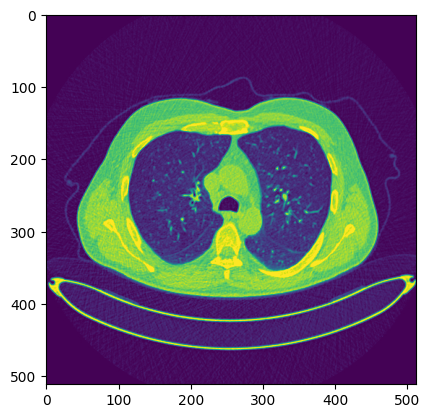

Malignant cases


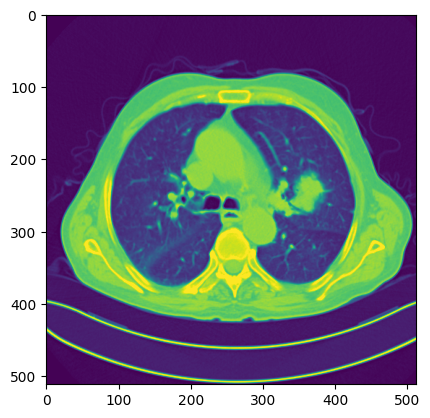

Normal cases


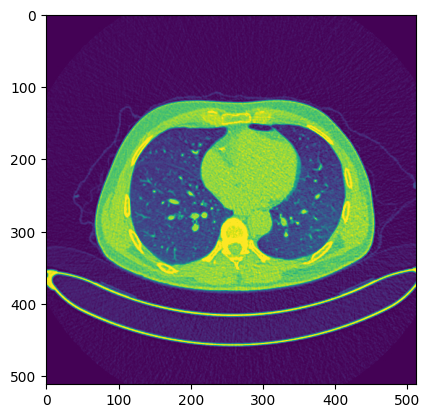

In [74]:
# print an image of each category
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

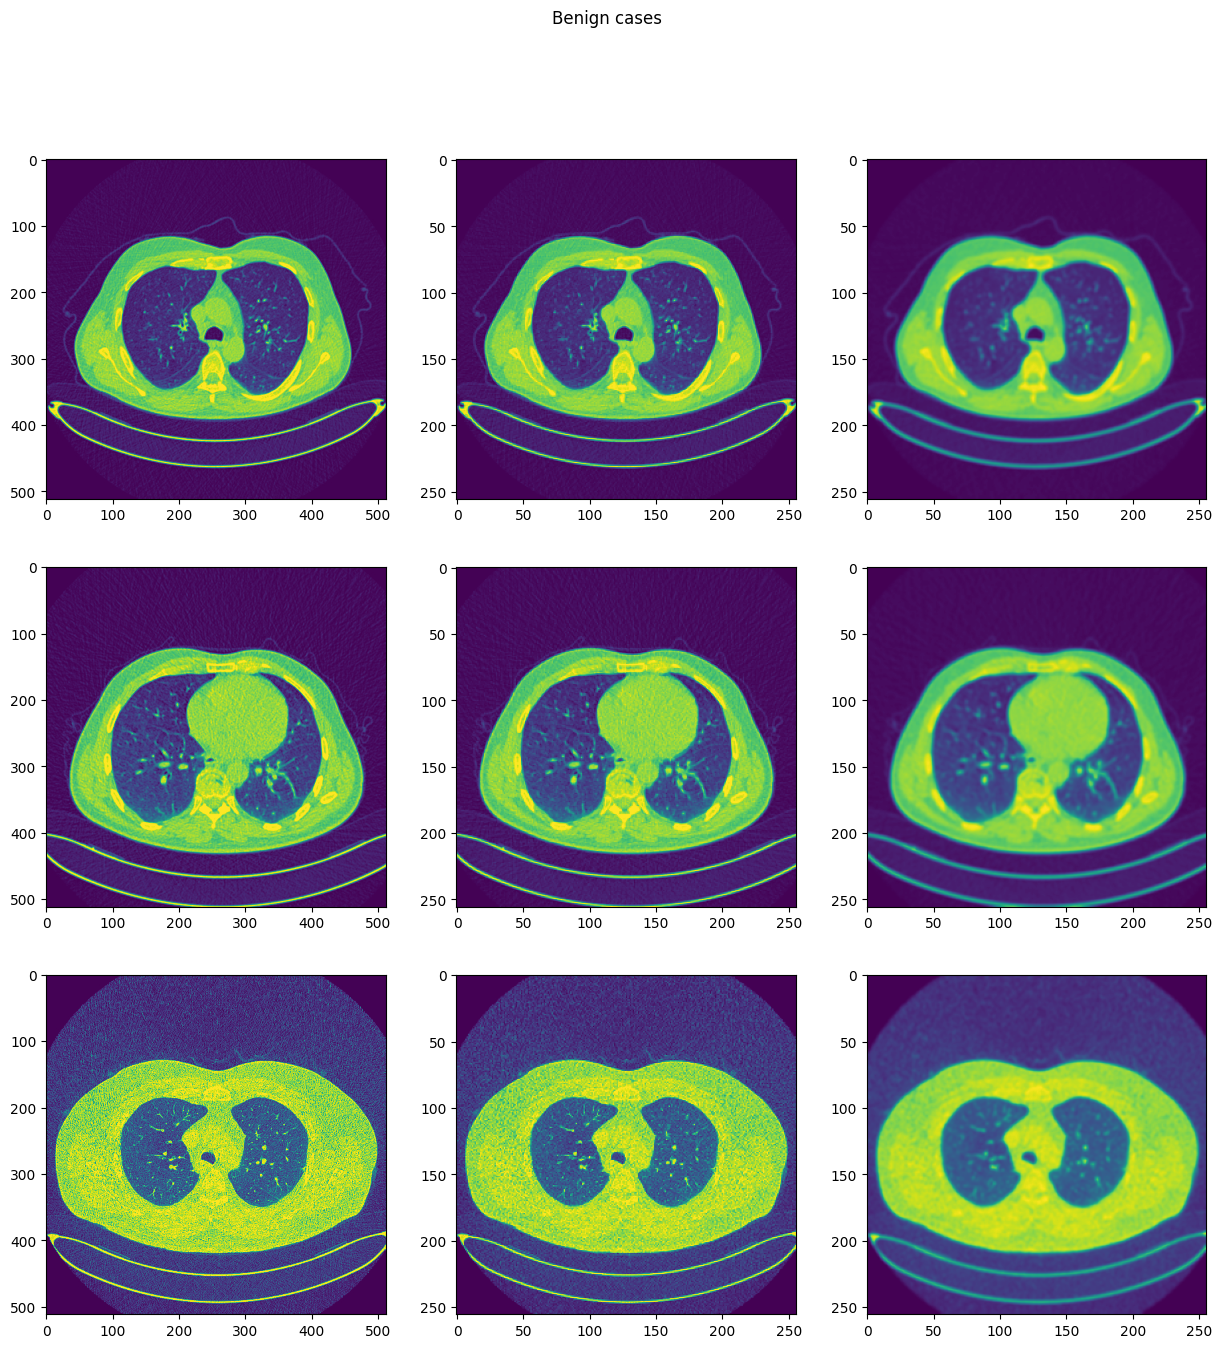

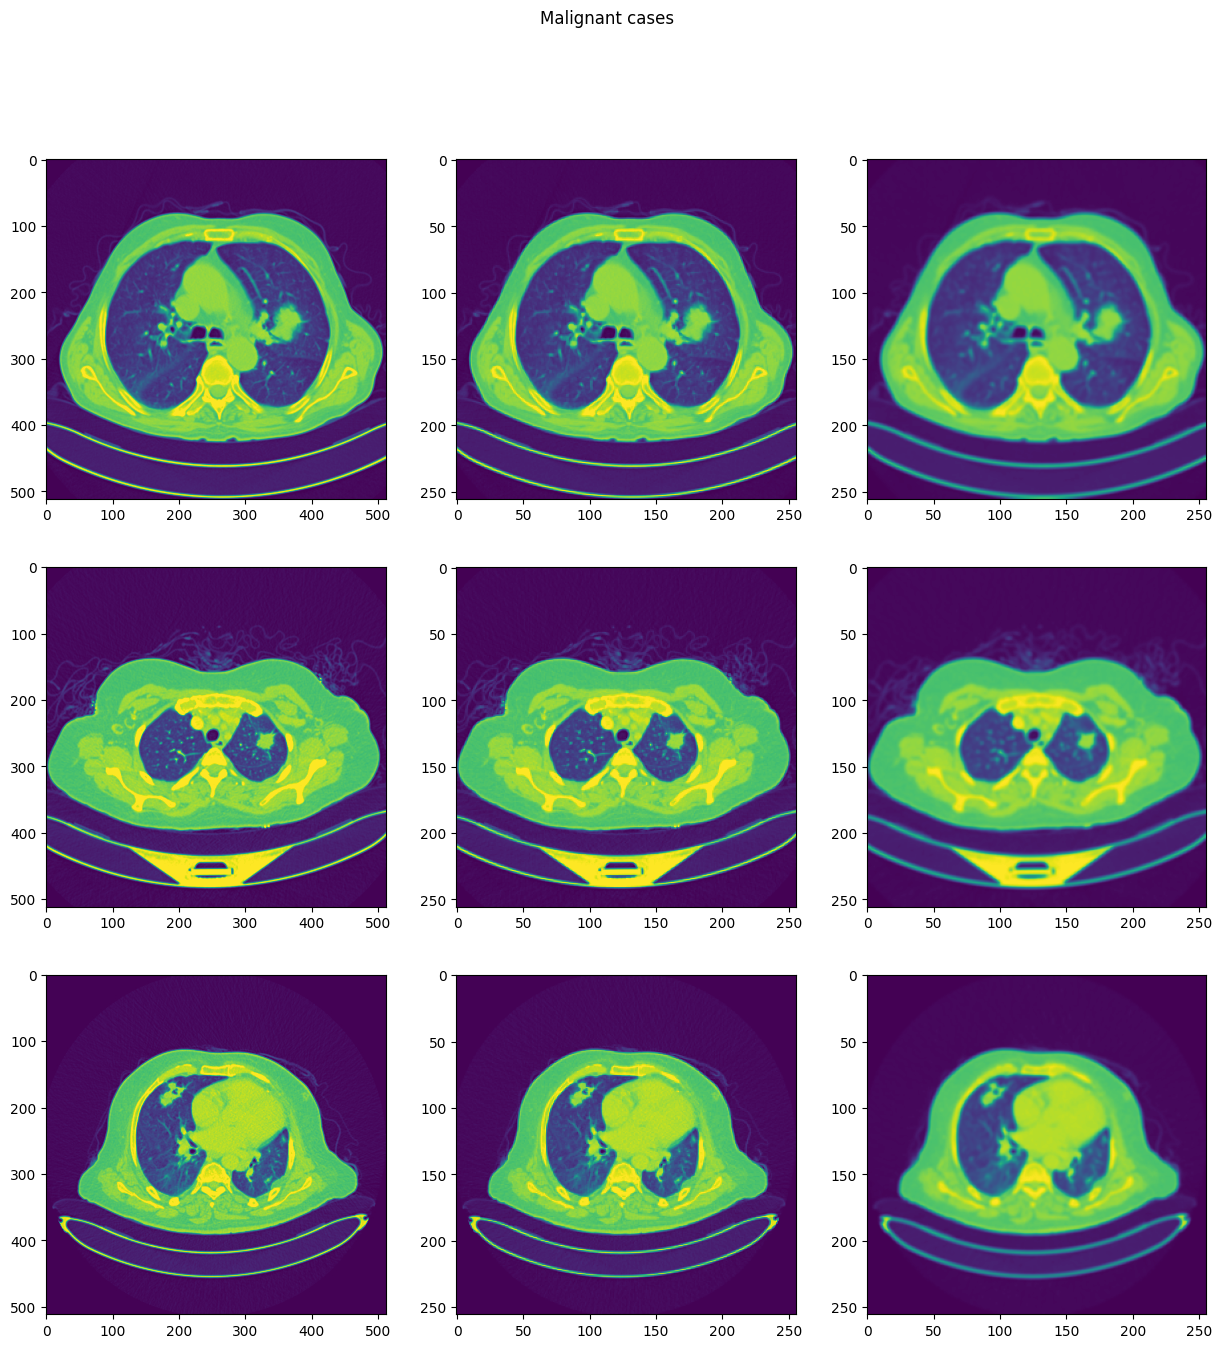

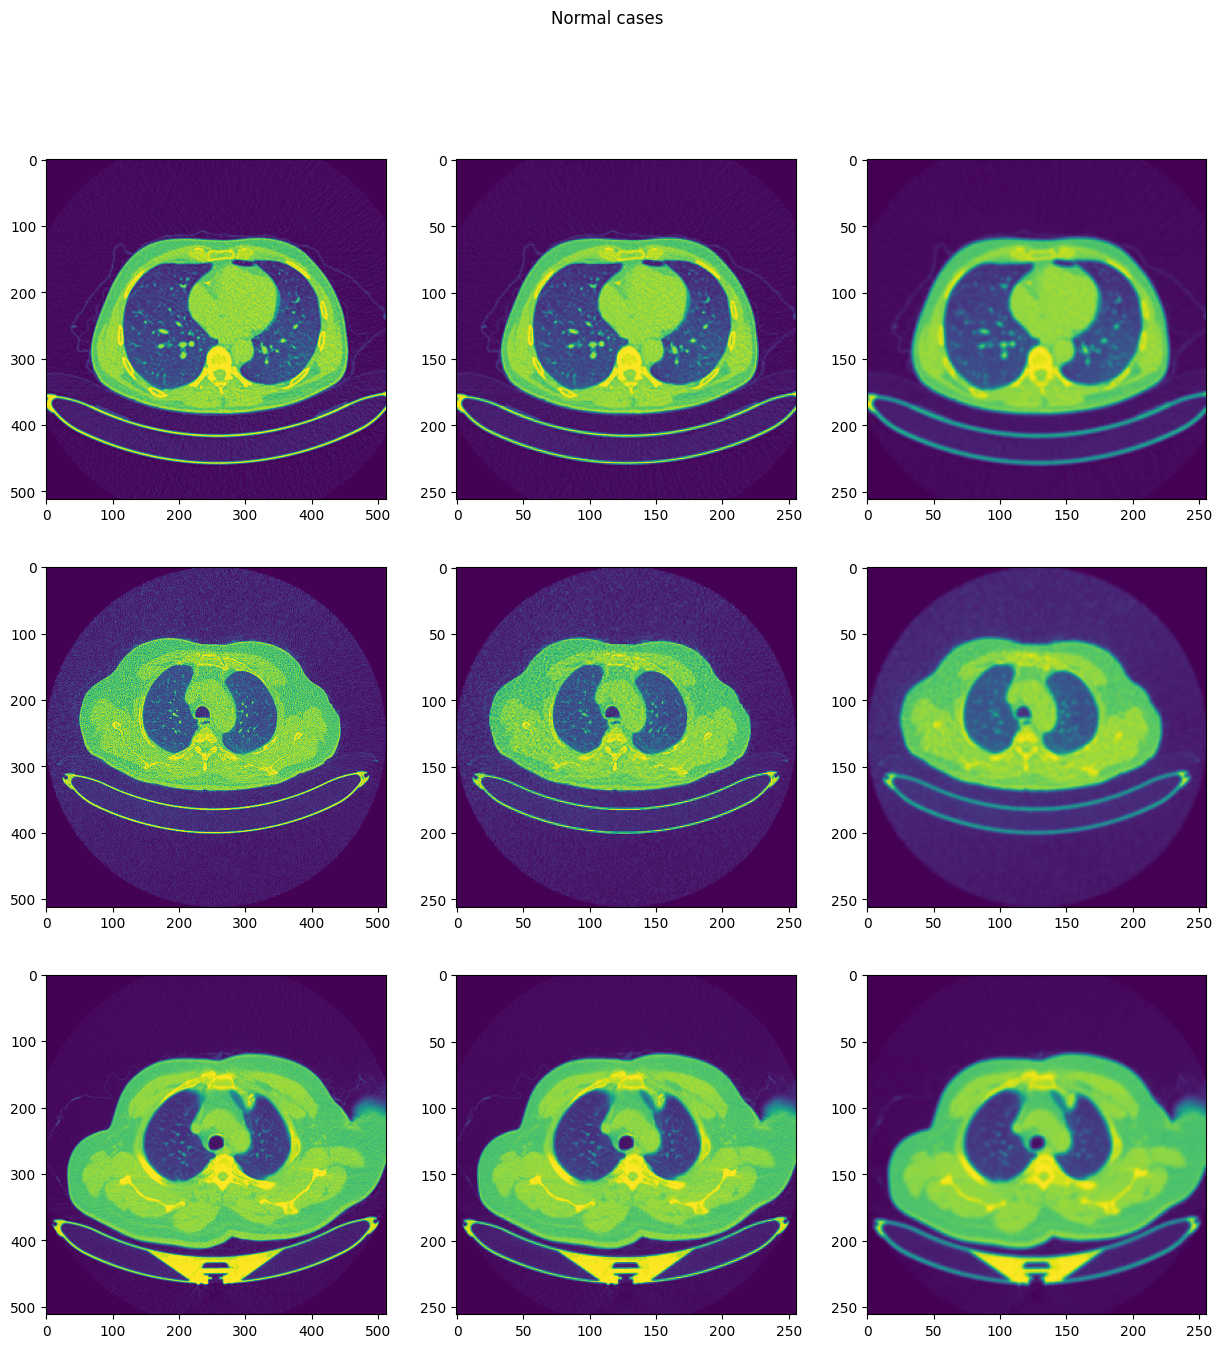

In [75]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)

        # resize image
        img0 = cv2.resize(img, (img_size, img_size))

        # apply Gaussian Blur
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)

        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break

plt.show()

In [76]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

# feature extraction
X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [77]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is 10% of the initial data set
# validation is 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

print(len(x_train), len(x_val), len(x_test))

822 165 110


In [78]:
print(Counter(y_train), Counter(y_val), Counter(y_test))

Counter({1: 418, 2: 319, 0: 85}) Counter({1: 86, 2: 58, 0: 21}) Counter({1: 57, 2: 39, 0: 14})


In [79]:
print(len(x_train), x_train.shape)

x_train = x_train.reshape(x_train.shape[0], img_size*img_size*1)
x_val = x_val.reshape(x_val.shape[0], img_size*img_size*1)

print(len(x_train), x_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [80]:
print('Before SMOTE train:', Counter(y_train))
print('Before SMOTE val:', Counter(y_val))

# applied SMOTE to equalize dataset
smote = SMOTE()
x_train_sampled, y_train_sampled = smote.fit_resample(x_train, y_train)
print('After SMOTE train:', Counter(y_train_sampled))
print('After SMOTE val:', Counter(y_val_sampled))

Before SMOTE train: Counter({1: 418, 2: 319, 0: 85})
Before SMOTE val: Counter({1: 86, 2: 58, 0: 21})
After SMOTE train: Counter({1: 418, 2: 418, 0: 418})
After SMOTE val: Counter({1: 79, 2: 79, 0: 79})


In [81]:
x_train = x_train.reshape(x_train.shape[0], img_size, img_size, 1)
x_train_sampled = x_train_sampled.reshape(x_train_sampled.shape[0], img_size, img_size, 1)
x_val = x_val.reshape(x_val.shape[0], img_size, img_size, 1)
x_val_sampled = x_val_sampled.reshape(x_val_sampled.shape[0], img_size, img_size, 1)
print(len(x_train), x_train.shape)
print(len(x_train_sampled), x_train_sampled.shape)
print(len(x_val), x_val.shape)
print(len(x_val_sampled), x_val_sampled.shape)

822 (822, 256, 256, 1)
1254 (1254, 256, 256, 1)
165 (165, 256, 256, 1)
237 (237, 256, 256, 1)


In [82]:
# building our CNN
model1 = Sequential()
dropout_level = 0.5

model1.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(dropout_level))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(dropout_level))


model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(dropout_level))

model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dropout(dropout_level))
model1.add(Dense(3, activation='softmax'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 64)      640       
                                                                 
 activation_4 (Activation)   (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 127, 127, 64)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [83]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
# training the model. This also includes back propagation
history = model1.fit(x_train_sampled, y_train_sampled, batch_size=8, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
157/157 [==============================] - 9s 47ms/step - loss: 1.1311 - accuracy: 0.4195 - val_loss: 1.0251 - val_accuracy: 0.6242
Epoch 2/50
157/157 [==============================] - 7s 44ms/step - loss: 0.7563 - accuracy: 0.6754 - val_loss: 0.4490 - val_accuracy: 0.8970
Epoch 3/50
157/157 [==============================] - 7s 46ms/step - loss: 0.3762 - accuracy: 0.8668 - val_loss: 0.1503 - val_accuracy: 0.9515
Epoch 4/50
157/157 [==============================] - 8s 54ms/step - loss: 0.2267 - accuracy: 0.9274 - val_loss: 0.1256 - val_accuracy: 0.9636
Epoch 5/50
157/157 [==============================] - 8s 52ms/step - loss: 0.1684 - accuracy: 0.9338 - val_loss: 0.1825 - val_accuracy: 0.9455
Epoch 6/50
157/157 [==============================] - 8s 50ms/step - loss: 0.1210 - accuracy: 0.9609 - val_loss: 0.0994 - val_accuracy: 0.9697
Epoch 7/50
157/157 [==============================] - 7s 45ms/step - loss: 0.0917 - accuracy: 0.9697 - val_loss: 0.0849 - val_accuracy: 0.9697

In [85]:
# print out performance metrics
y_pred = model1.predict(x_test, verbose=1)

y_pred_bool = np.argmax(y_pred, axis=1)

correct = 0
for i in range(len(y_pred_bool)):
  if y_pred_bool[i] == y_test[i]:
    correct += 1
accuracy = correct/110
print(accuracy)

print(classification_report(y_test, y_pred_bool))

print(confusion_matrix(y_true=y_test, y_pred=y_pred_bool))

4/4 [==============================] - 0s 25ms/step
0.990909090909091
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       1.00      1.00      1.00        57
           2       0.97      1.00      0.99        39

    accuracy                           0.99       110
   macro avg       0.99      0.98      0.98       110
weighted avg       0.99      0.99      0.99       110

[[13  0  1]
 [ 0 57  0]
 [ 0  0 39]]


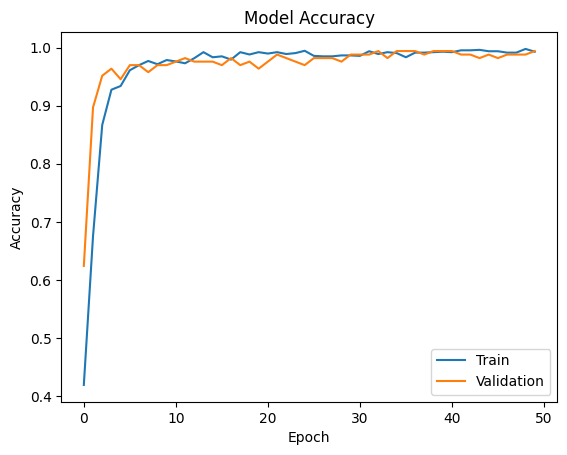

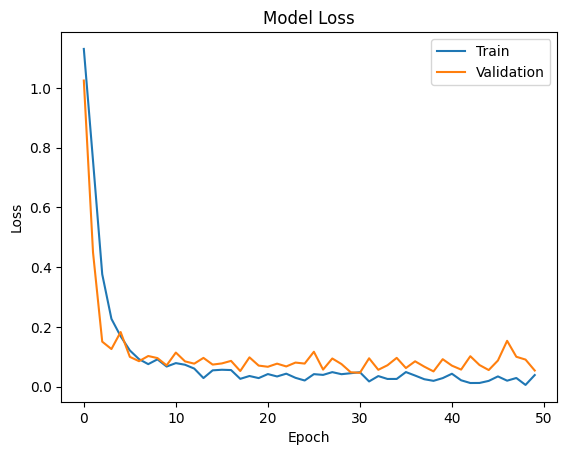

In [86]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()